In [29]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys
import pymc as pm
from pymc.sampling_jax import get_jaxified_graph
from pymc import Model
from typing import Callable

import numpy as np
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal
from functools import partial

import blackjax
import blackjax.smc.resampling as resampling
from pymc.sampling_jax import get_jaxified_logp
import arviz as az

jax.config.update("jax_enable_x64", True)

from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

%matplotlib inline
plt.style.use('~/.matplotlib/custom.mplstyle')
# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *

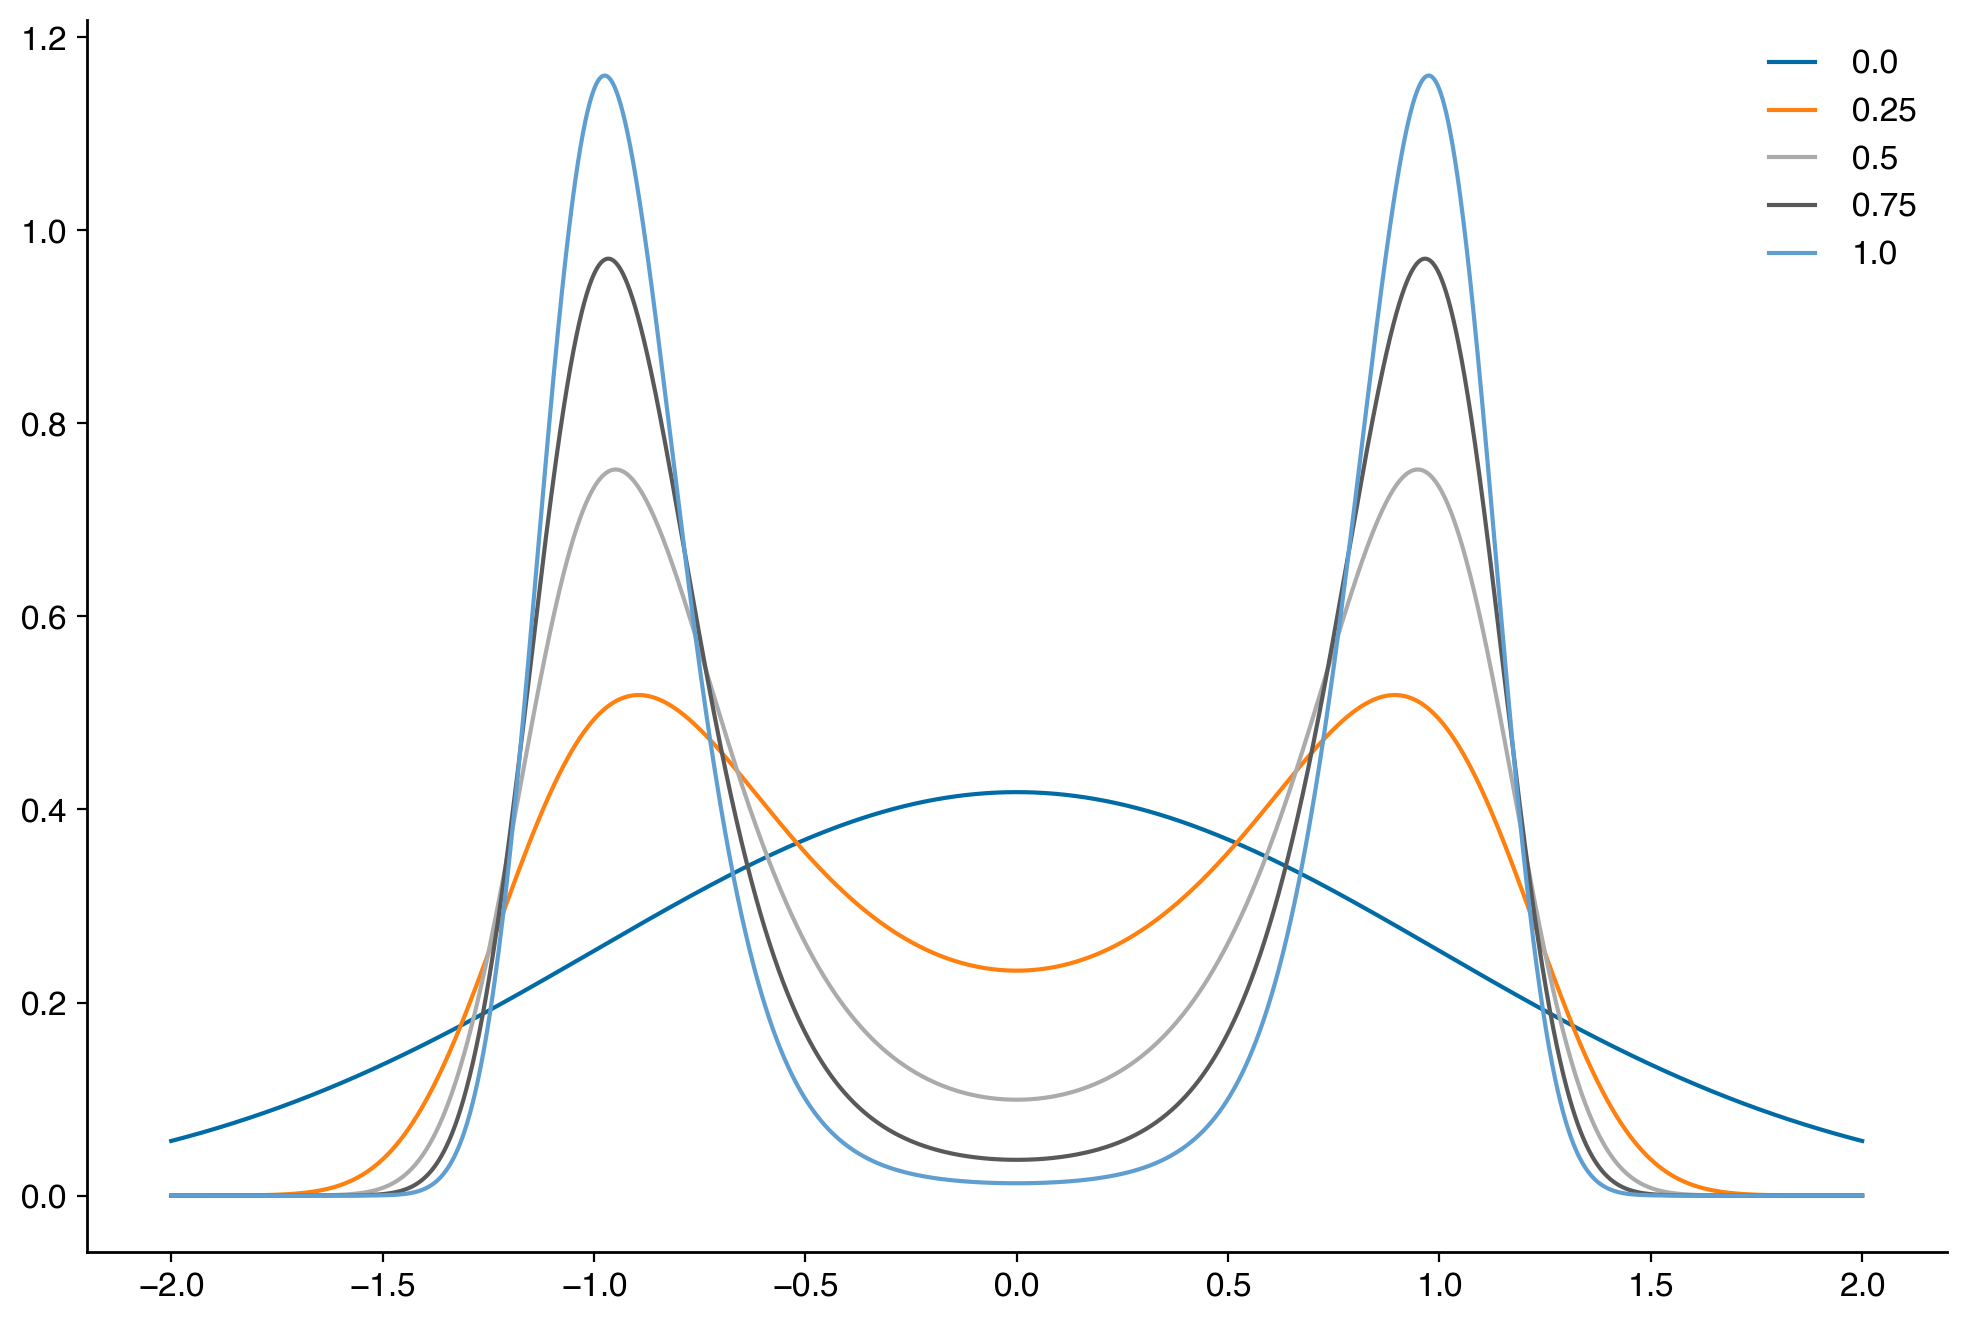

In [2]:
def V(x):
    return 5 * jnp.square(jnp.sum(x**2, axis=-1) - 1)


def prior_log_prob(x):
    d = x.shape[-1]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d))


linspace = jnp.linspace(-2, 2, 5000)[..., None]
lambdas = jnp.linspace(0.0, 1.0, 5)
prior_logvals = prior_log_prob(linspace)
potential_vals = V(linspace)
log_res = prior_logvals - lambdas[..., None] * potential_vals

density = jnp.exp(log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (
    linspace[1] - linspace[0]
)
density /= normalizing_factor

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(linspace.squeeze(), density.T)
ax.legend(list(lambdas));

In [3]:
def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, k):
        state, _ = mcmc_kernel(k, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


def full_logdensity(x):
    return -V(x) + prior_log_prob(x)


inv_mass_matrix = jnp.eye(1)
n_samples = 10_000

#### Sample with HMC

In [4]:
%%time

hmc_parameters = dict(
    step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=50
)

hmc = blackjax.hmc(full_logdensity, **hmc_parameters)
hmc_state = hmc.init(jnp.ones((1,)))

rng_key, sample_key = jax.random.split(rng_key)
hmc_samples = inference_loop(sample_key, hmc.step, hmc_state, n_samples)

CPU times: user 573 ms, sys: 22.1 ms, total: 595 ms
Wall time: 592 ms


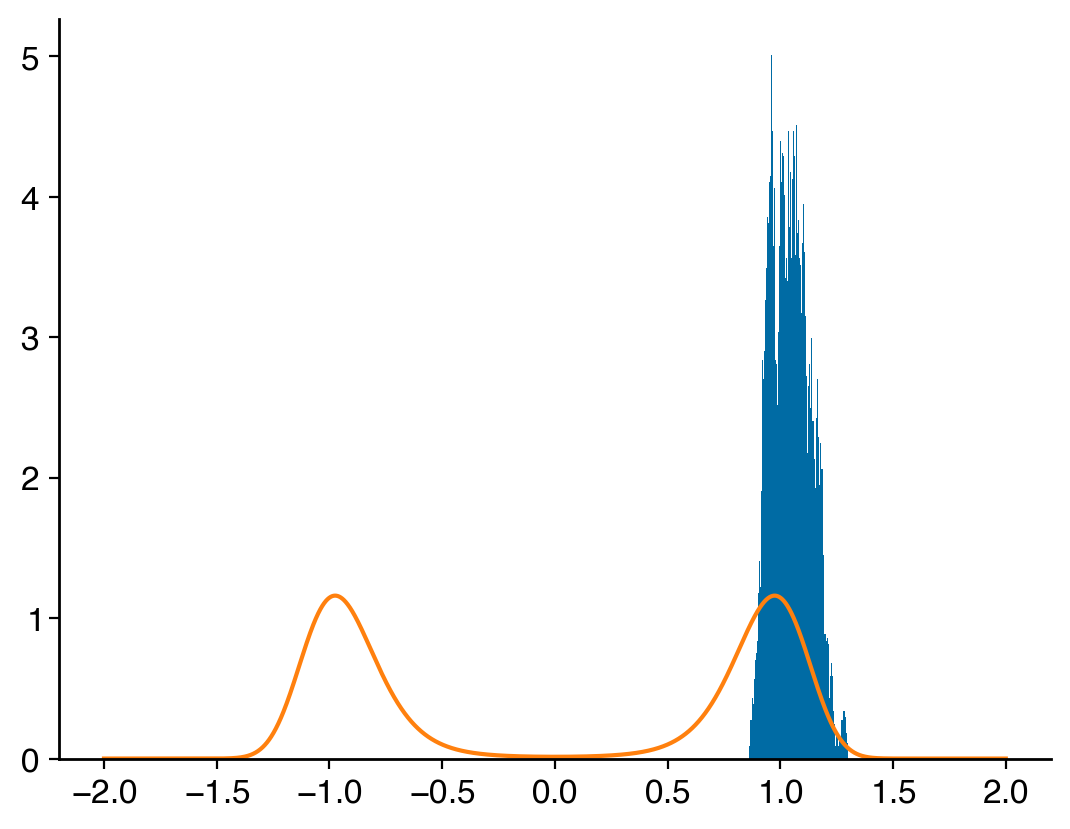

In [5]:
samples = np.array(hmc_samples.position[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

CPU times: user 2.3 s, sys: 16.1 ms, total: 2.32 s
Wall time: 2.31 s


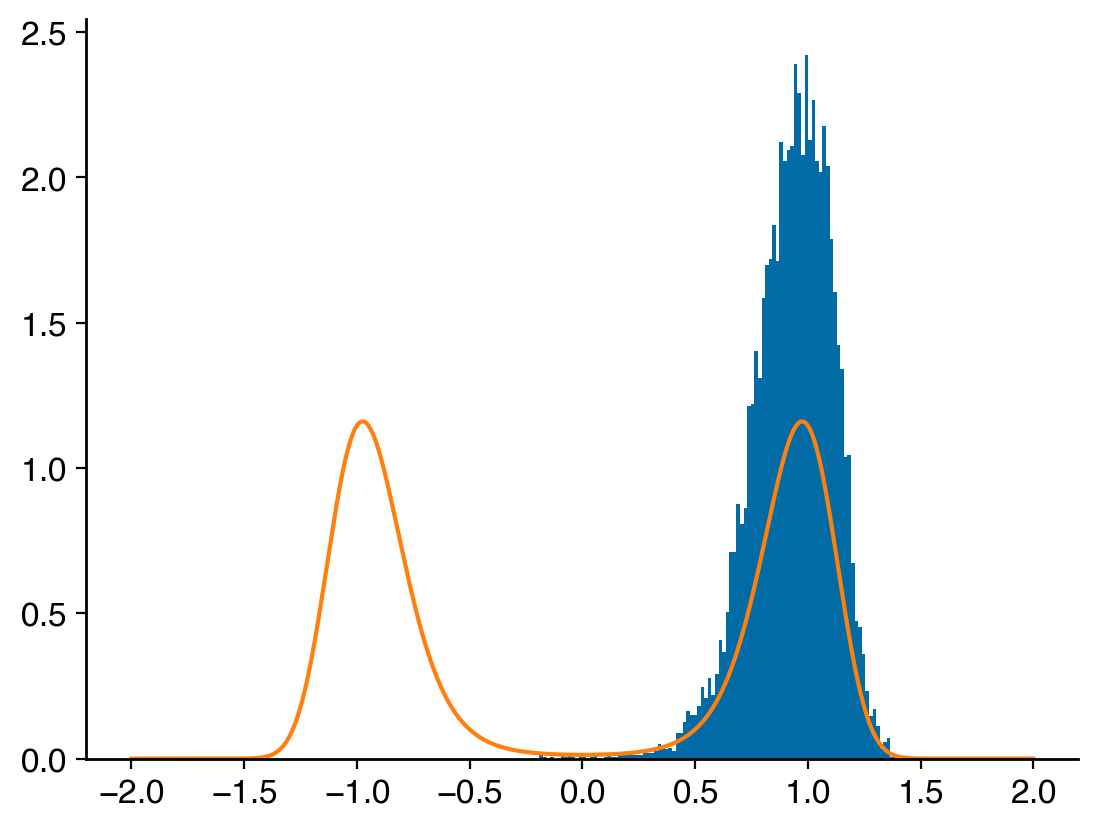

In [6]:
%%time

nuts_parameters = dict(step_size=1e-4, inverse_mass_matrix=inv_mass_matrix)

nuts = blackjax.nuts(full_logdensity, **nuts_parameters)
nuts_state = nuts.init(jnp.ones((1,)))

rng_key, sample_key = jax.random.split(rng_key)
nuts_samples = inference_loop(sample_key, nuts.step, nuts_state, n_samples)

samples = np.array(nuts_samples.position[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

## Now try SMC

In [7]:
def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the temepered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, _k = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return i + 1, state, k

    n_iter, final_state, _ = jax.lax.while_loop(
        cond, one_step, (0, initial_state, rng_key)
    )

    return n_iter, final_state

In [8]:
%%time

loglikelihood = lambda x: -V(x)

hmc_parameters = dict(
    step_size=1e-4, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=1
)

tempered = blackjax.adaptive_tempered_smc(
    prior_log_prob,
    loglikelihood,
    blackjax.hmc.build_kernel(),
    blackjax.hmc.init,
    hmc_parameters,
    resampling.systematic,
    0.5,
    num_mcmc_steps=1,
)

rng_key, init_key, sample_key = jax.random.split(rng_key, 3)
initial_smc_state = jax.random.multivariate_normal(
    init_key, jnp.zeros([1]), jnp.eye(1), (n_samples,)
)
initial_smc_state = tempered.init(initial_smc_state)

n_iter, smc_samples = smc_inference_loop(sample_key, tempered.step, initial_smc_state)
print("Number of steps in the adaptive algorithm: ", n_iter.item())

Number of steps in the adaptive algorithm:  12
CPU times: user 1.04 s, sys: 87.1 ms, total: 1.13 s
Wall time: 1.05 s


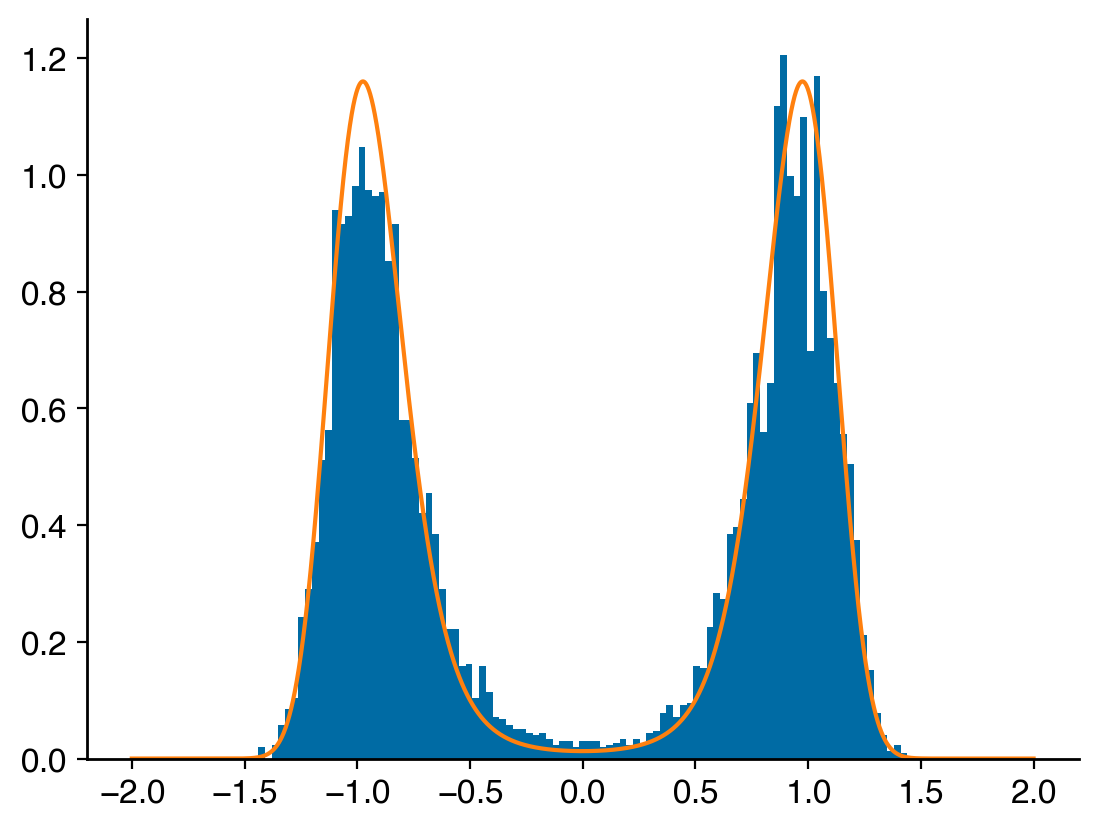

In [9]:
samples = np.array(smc_samples.particles[:, 0])
_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

### Try this with a PyMC model

In [24]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as model:

    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    tau = pm.HalfCauchy("tau", 5.0)

    theta = pm.Normal("theta", mu=0, sigma=1, shape=J)
    theta_1 = mu + tau * theta
    obs = pm.Normal("obs", mu=theta_1, sigma=sigma, shape=J, observed=y)

from pymc.sampling_jax import get_jaxified_logp

rvs = [rv.name for rv in model.value_vars]
logdensity_fn = get_jaxified_logp(model)

# test_points = {'mu': jnp.array(1.0), 'tau': jnp.array(1.0), 'theta': jnp.array(1.0)}
# tmp = 'pm.logp('
# for i, rv in enumerate(model.unobserved_RVs):
#     tmp += rv.name + '=' + str(test_points[rv.name]) + ', '
# tmp += ')'
# print(eval(tmp))

test_points = jnp.array([1.0, 1.0, 1.0])

In [40]:
rvs = [rv.name for rv in model.value_vars]
init_position_dict = model.initial_point()
init_position = [init_position_dict[rv] for rv in rvs]

# unobserved_RVs = [rv.name for rv in model.unobserved_RVs]
# init_position_dict = model.initial_point()
# init_position = [init_position_dict[rv] for rv in unobserved_RVs]
# print(init_position)

log_p_fn = get_jaxified_prior_logp(model)
print(log_p_fn(init_position))

MissingInputError: Input 0 (tau_log__) of the graph (indices start from 0), used to compute Exp(tau_log__), was not provided and not given a value. Use the PyTensor flag exception_verbosity='high', for more information on this error.
 
Backtrace when that variable is created:

  File "/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_90621/3157485807.py", line 8, in <module>
    tau = pm.HalfCauchy("tau", 5.0)
  File "/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/pymc/distributions/distribution.py", line 316, in __new__
    rv_out = model.register_rv(
  File "/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/pymc/model/core.py", line 1292, in register_rv
    self.create_value_var(rv_var, transform)
  File "/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/pymc/model/core.py", line 1445, in create_value_var
    value_var = transform.forward(rv_var, *rv_var.owner.inputs).type()


In [115]:
def log_prior(values, model):
    return sum(
        [
            pm.logp(model.unobserved_RVs[0], values[0]).eval(),
            pm.logp(model.unobserved_RVs[1], values[1]).eval(),
            pm.logp(model.unobserved_RVs[2], values[2]).eval(),
        ]
    )

values = jnp.array([0.0, 5.0, 0.0]

log_prior(values, model)

-6.8946299557822375

In [91]:
model.unobserved_RVs

[mu, tau, theta]

[(mu, 0.0), (tau, 5.0), (theta, array([0., 0., 0., 0., 0., 0., 0., 0.]))]

In [ ]:
model.free_RVs[0]